In [60]:
import glob
import os
import numpy as np

import requests

import copy
import numpy as np
import pandas as pd

from pcmdi_metrics.graphics import read_mean_clim_json_files
from pcmdi_metrics.graphics import normalize_by_median

In [61]:
import mplsettings
mplsettings.setup_plots()

# Generate a PCMDI metrics portrait plot @ GFDL

This notebook illustrates how to generate a portrait plot with PCMDI Metrics. The notes here borrow heavily from the tutorial put together by Jiwoo Lee, with some GFDL site-specific modifications.

## Pre-computed metrics

The pre-computed metrics from the `pcmdi_metrics_results_archive` are downloaded to the central install location.

In [81]:
pmp_data_root = "/home/mdteam/pcmdi_metrics"

# CMIP6 `amip` simulations
amip_json_files = glob.glob(
    f"{pmp_data_root}/pcmdi_metrics_results_archive/metrics_results/"
    + "mean_climate/cmip6/amip/v20210830/*.json"
)

# CMIP6 `historical` simulations
historical_json_files = glob.glob(
    f"{pmp_data_root}/pcmdi_metrics_results_archive/metrics_results/"
    + "mean_climate/cmip6/historical/v20210811/*.json"
)

In [82]:
historical_json_files

['/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/pr.cmip6.historical.regrid2.2p5x2p5.v20210811.json',
 '/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/prw.cmip6.historical.regrid2.2p5x2p5.v20210811.json',
 '/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/psl.cmip6.historical.regrid2.2p5x2p5.v20210811.json',
 '/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/rlds.cmip6.historical.regrid2.2p5x2p5.v20210811.json',
 '/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/rltcre.cmip6.historical.regrid2.2p5x2p5.v20210811.json',
 '/home/mdteam/pcmdi_metrics/pcmdi_metrics_results_archive/metrics_results/mean_climate/cmip6/historical/v20210811/rlus.cmip6.historical.regrid2.2p5x2p5

## The `Metrics` class instance

This class instance below was written by J. Krasting (GFDL) to make it easier to merge new test cases / experiments with the existing pre-computed metrics libraries. Users *** should not need to modify *** this class below.  PCMDI will also be using this class in PMP versions > 2.2.2.

In [83]:
class Metrics:
    """Mean climate metrics object class"""

    def __init__(self, files):
        """Initialize the mean climate metrics class

        This method initializes the mean climate metrics object given a
        single json file, a list of json files, or a directory containing
        a set of json files.

        Parameters
        ----------
        files : str, path-like or list
            Input json file(s) or directory containing json files

        Returns
        -------
        Metrics
            mean climte metrics object class
        """

        # if `files` input is a string, determine if it is a single file
        # or if it is a directory containing json files

        if isinstance(files, str):

            assert os.path.exists(files), "Specified path does not exist."

            if os.path.isfile(files):
                files = [files]
            elif os.path.isdir(files):
                files = glob.glob(f"{files}/*.json")

        else:

            assert isinstance(
                files, list
            ), "Input must either be a single file, directory, or list of files."

        # call `read_mean_clim_json_files` and save the results as
        # object attributes

        (
            self.df_dict,
            self.var_list,
            self.var_unit_list,
            self.regions,
            self.stats,
        ) = read_mean_clim_json_files(files)

    def copy(self):
        """method to deep copy a Metrics instance"""
        return copy.deepcopy(self)

    def merge(self, metrics_obj):
        """Method to merge Metrics instance with another instance

        This method merges an existing metrics instance with another instance
        by finding the superset of stats, seasons, and regions across the
        two instances

        Parameters
        ----------
        metrics_obj : Metrics
            Metrics object to merge with exisiting instance

        Returns
        -------
        Metrics
            merged Metrics instance
        """

        # ensure that second `metrics_obj` is a Metrics object
        assert isinstance(
            metrics_obj, Metrics
        ), "Metrics objects must be merged with other Metrics objects"

        # make a copy of the existing instance as the result
        result = self.copy()

        # loop over superset of `stats`
        stats = set(self.df_dict.keys()).union(metrics_obj.df_dict.keys())
        for stat in sorted(stats):

            # loop over superset of seasons
            seasons = set(self.df_dict[stat].keys()).union(
                metrics_obj.df_dict[stat].keys()
            )
            for season in seasons:

                # loop over superset of regions
                regions = set(self.df_dict[stat][season].keys()).union(
                    metrics_obj.df_dict[stat][season].keys()
                )
                for region in regions:

                    # consider both the current Metrics instance and
                    # candidate `metrics_obj` instance and determine if the
                    # [stat][season][region] nesting contains a pd.DataFrame.
                    # If a KeyError is thrown, it likely does not exist
                    # and initialize an empty pd.DataFrame. If some other
                    # exception occurs, raise it.

                    try:
                        _df1 = self.df_dict[stat][season][region]
                        assert isinstance(
                            _df1, pd.core.frame.DataFrame
                        ), "Unexpected object found"
                    except Exception as exception:
                        if isinstance(exception, KeyError):
                            _df1 = pd.DataFrame()
                        else:
                            raise exception

                    try:
                        _df2 = metrics_obj.df_dict[stat][season][region]
                        assert isinstance(
                            _df2, pd.core.frame.DataFrame
                        ), "Unexpected object found"
                    except Exception as exception:
                        if isinstance(exception, KeyError):
                            _df2 = pd.DataFrame()
                        else:
                            raise exception

                    # concatenate `merge_obj` to the end of the current
                    # instance. Fill `None` types as np.nan to avoid potential
                    # issues with future funcs, such as `normalize_by_median`

                    result.df_dict[stat][season][region] = pd.concat(
                        [_df1, _df2], ignore_index=True
                    ).fillna(value=np.nan)

        # determine the superset of the other attributes

        result.var_list = list(set(self.var_list + metrics_obj.var_list))
        result.var_unit_list = list(set(self.var_unit_list + metrics_obj.var_unit_list))
        result.regions = list(set(self.regions + metrics_obj.regions))
        result.stats = list(set(self.stats + metrics_obj.stats))

        return result

### Load the pre-computed library as a `Metrics` instance

In [84]:
#library = Metrics(amip_json_files)
library = Metrics(historical_json_files)

### Load the new experiment(s) also as a `Metrics` instance 

In [119]:
new_json_result_files_25 = glob.glob("pmp_results_CM4_historical_c192_OM4p25/results/*.json")
new_experiment_25 = Metrics(new_json_result_files_25)

In [120]:
new_json_result_files_125 = glob.glob("pmp_results_CM4_historical_c192_OM4p125/results/*.json")
new_experiment_125 = Metrics(new_json_result_files_125)

In [121]:
new_json_cm4 = glob.glob("pmp_results_CM4_historical/results/*.json")
new_experiment_cm4 = Metrics(new_json_cm4)

In [122]:
new_json_esm4 = glob.glob("pmp_results_ESM4_historical/results/*.json")
new_experiment_esm4 = Metrics(new_json_esm4)

### Merge the new experiment with the existing library

In [123]:
merged_results = new_experiment_esm4.merge(new_experiment_cm4)
merged_results = merged_results.merge(new_experiment_25)
merged_results = merged_results.merge(new_experiment_125)

In [124]:
df_dict = merged_results.df_dict
var_list = merged_results.var_list
var_unit_list = merged_results.var_unit_list
regions = merged_results.regions
stats = merged_results.stats

In [125]:
print('var_list:', var_list)
print('var_unit_list:', var_unit_list)

var_list: ['ua-850', 'psl', 'tauu', 'ua-200', 'rsus', 'rsdscs', 'prw', 'rsdt', 'zg-500', 'rlds', 'va-850', 'rsut', 'va-200', 'rsutcs', 'ta-850', 'rsds', 'sfcWind', 'ta-200', 'pr', 'tauv', 'rlut', 'tas', 'rlus', 'rlutcs']
var_unit_list: ['zg-500 [m]', 'ua-200 [m s-1]', 'rsdt [W m-2]', 'rlut [W m-2]', 'rlds [W m-2]', 'sfcWind [m s-1]', 'tas [K]', 'pr [kg m-2 s-1]', 'rlutcs [W m-2]', 'va-200 [m s-1]', 'psl [Pa]', 'va-850 [m s-1]', 'rsdscs [W m-2]', 'rsut [W m-2]', 'ta-850 [K]', 'ta-200 [K]', 'rsds [W m-2]', 'tauv [Pa]', 'rsutcs [W m-2]', 'tauu [Pa]', 'ua-850 [m s-1]', 'prw [kg m-2]', 'rlus [W m-2]', 'rsus [W m-2]']


In [92]:
_dff = df_dict['rms_xy']['djf']['global']
_dff = _dff[(_dff["model"] == "GFDL-CM4") | (_dff["model"] == "GFDL-ESM4") | (_dff["model"] == "CM4_historical_c192_OM4p25") | (_dff["model"] == "CM4_historical_c192_OM4p125")]
df_dict['rms_xy']['djf']['global'] = _dff

_dff = df_dict['rms_xy']['mam']['global']
_dff = _dff[(_dff["model"] == "GFDL-CM4") | (_dff["model"] == "GFDL-ESM4") | (_dff["model"] == "CM4_historical_c192_OM4p25") | (_dff["model"] == "CM4_historical_c192_OM4p125")]
df_dict['rms_xy']['mam']['global'] = _dff

_dff = df_dict['rms_xy']['jja']['global']
_dff = _dff[(_dff["model"] == "GFDL-CM4") | (_dff["model"] == "GFDL-ESM4") | (_dff["model"] == "CM4_historical_c192_OM4p25") | (_dff["model"] == "CM4_historical_c192_OM4p125")]
df_dict['rms_xy']['jja']['global'] = _dff

_dff = df_dict['rms_xy']['son']['global']
_dff = _dff[(_dff["model"] == "GFDL-CM4") | (_dff["model"] == "GFDL-ESM4") | (_dff["model"] == "CM4_historical_c192_OM4p25") | (_dff["model"] == "CM4_historical_c192_OM4p125")]
df_dict['rms_xy']['son']['global'] = _dff

_dff = df_dict['rms_xyt']['ann']['global']
_dff = _dff[(_dff["model"] == "GFDL-CM4") | (_dff["model"] == "GFDL-ESM4") | (_dff["model"] == "CM4_historical_c192_OM4p25") | (_dff["model"] == "CM4_historical_c192_OM4p125")]
df_dict['rms_xyt']['ann']['global'] = _dff

In [126]:
#var_list = ["pr", "psl", "rltcre", "rlut", "rstcre", "rsut", "ta-200", "ta-850", "tas", "ts",
#            "ua-200", "ua-850", "va-200", "va-850", "zg-500"]

In [127]:
# Simple re-order variables
if 'zg-500' in var_list and 'sfcWind' in var_list:
    var_list.remove('zg-500')
    idx_sfcWind = var_list.index('sfcWind')
    var_list.insert(idx_sfcWind+1, 'zg-500')

#not showing up?
var_list.remove("rlut")
var_list.remove("rsus")
var_list.remove("tauv")
    
print("var_list:", var_list)

var_list: ['ua-850', 'psl', 'tauu', 'ua-200', 'rsdscs', 'prw', 'rsdt', 'rlds', 'va-850', 'rsut', 'va-200', 'rsutcs', 'ta-850', 'rsds', 'sfcWind', 'zg-500', 'ta-200', 'pr', 'tas', 'rlus', 'rlutcs']


In [128]:
data_djf = df_dict['rms_xy']['djf']['global'][var_list].to_numpy()
data_mam = df_dict['rms_xy']['mam']['global'][var_list].to_numpy()
data_jja = df_dict['rms_xy']['jja']['global'][var_list].to_numpy()
data_son = df_dict['rms_xy']['son']['global'][var_list].to_numpy()
model_names = df_dict['rms_xyt']['ann']['global']['model'].tolist()
data_all = np.stack([data_djf, data_mam, data_jja, data_son])
print('data.shape:', data_all.shape)
print('len(var_list): ', len(var_list))
print('len(model_names): ', len(model_names))

xaxis_labels = var_list
yaxis_labels = model_names

data.shape: (4, 4, 21)
len(var_list):  21
len(model_names):  4


In [129]:
df_dict['rms_xy']['djf']['global'][var_list]

,ua-850,psl,tauu,ua-200,rsdscs,prw,rsdt,rlds,va-850,rsut,...,rsutcs,ta-850,rsds,sfcWind,zg-500,ta-200,pr,tas,rlus,rlutcs
0,1.339,203.267,0.028,2.638,5.981,139.073,2.001,12.361,0.710,12.064,...,8.975,1.394,13.756,562.918,28.654,1.622,1.350,1.970,8.937,6.690
1,1.340,196.913,0.027,2.883,6.684,139.043,2.001,14.175,0.698,11.830,...,8.997,1.728,14.029,562.934,40.200,1.989,1.312,2.201,9.323,7.995
2,1.202,207.879,0.023,2.422,6.183,138.994,1.995,13.402,0.578,9.686,...,8.942,1.409,12.581,562.837,32.255,1.468,1.190,2.044,9.311,7.396
3,1.131,208.323,0.023,2.617,6.142,139.009,1.995,12.114,0.626,9.825,...,7.989,1.258,12.504,562.831,26.873,1.326,1.233,1.896,8.442,7.054


### Normalize each column by its median

Use `normalize_by_median` function.

#### Parameters
- `data`: 2d numpy array
- `axis`: 0 (normalize each column) or 1 (normalize each row), default=0 

#### Return
- `data_nor`: 2d numpy array

In [130]:
data_djf

array([[1.33900e+00, 2.03267e+02, 2.80000e-02, 2.63800e+00, 5.98100e+00,
        1.39073e+02, 2.00100e+00, 1.23610e+01, 7.10000e-01, 1.20640e+01,
        1.43600e+00, 8.97500e+00, 1.39400e+00, 1.37560e+01, 5.62918e+02,
        2.86540e+01, 1.62200e+00, 1.35000e+00, 1.97000e+00, 8.93700e+00,
        6.69000e+00],
       [1.34000e+00, 1.96913e+02, 2.70000e-02, 2.88300e+00, 6.68400e+00,
        1.39043e+02, 2.00100e+00, 1.41750e+01, 6.98000e-01, 1.18300e+01,
        1.36700e+00, 8.99700e+00, 1.72800e+00, 1.40290e+01, 5.62934e+02,
        4.02000e+01, 1.98900e+00, 1.31200e+00, 2.20100e+00, 9.32300e+00,
        7.99500e+00],
       [1.20200e+00, 2.07879e+02, 2.30000e-02, 2.42200e+00, 6.18300e+00,
        1.38994e+02, 1.99500e+00, 1.34020e+01, 5.78000e-01, 9.68600e+00,
        1.20500e+00, 8.94200e+00, 1.40900e+00, 1.25810e+01, 5.62837e+02,
        3.22550e+01, 1.46800e+00, 1.19000e+00, 2.04400e+00, 9.31100e+00,
        7.39600e+00],
       [1.13100e+00, 2.08323e+02, 2.30000e-02, 2.61700e+00

In [131]:
data_djf_nor = normalize_by_median(data_djf)
data_mam_nor = normalize_by_median(data_mam)
data_jja_nor = normalize_by_median(data_jja)
data_son_nor = normalize_by_median(data_son)

In [132]:
data_all_nor = np.stack([data_djf_nor, data_mam_nor, data_jja_nor, data_son_nor])
data_all_nor.shape

(4, 4, 21)

## 2. Matplotlib-based PMP Visualization Function

In [133]:
from pcmdi_metrics.graphics import portrait_plot

<p id="parameters"></p>

Parameters
----------
- `data`: 2d numpy array, a list of 2d numpy arrays, or a 3d numpy array (i.e. stacked 2d numpy arrays)
- `xaxis_labels`: list of strings, labels for xaixs. Number of list element must consistent to x-axis, or 0 (empty list) to turn off xaxis tick labels
- `yaxis_labels`: list of strings, labels for yaxis. Number of list element must consistent to y-axis, or 0 (empty list) to turn off yaxis tick labels
- `fig`: [`matplotlib.figure`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html) instance to which the portrait plot is plotted.  If not provided, use current axes or create a new one.  Optional.
- `ax`: [`matplotlib.axes.Axes`](https://matplotlib.org/stable/api/axes_api.html) instance to which the portrait plot is plotted.  If not provided, use current axes or create a new one.  Optional.
- `annotate`: bool, default=False, add annotating text if true, but work only for heatmap style map (i.e., no triangles)
- `annotate_data`: 2d numpy array, default=None. If None, the image's data is used.  Optional. 
- `annotate_fontsize`: number (int/float), default=15. Font size for annotation
- `annotate_format`: format for annotate value, default="{x:.2f}"
- `figsize`: tuple of two numbers (width, height), default=(12, 10), figure size in inches
- `vrange`: tuple of two numbers, range of value for colorbar.  Optional.
- `xaxis_fontsize`: number, default=15, font size for xaxis tick labels
- `yaxis_fontsize`: number, default=15, font size for yaxis tick labels
- `cmap`: string, default="RdBu_r", name of matplotlib colormap
- `cmap_bounds`: list of numbers.  If given, discrete colors are applied.  Optional.
- `cbar_label`: string, default=None, label for colorbar
- `cbar_label_fontsize`: number, default=15, font size for colorbar labels
- `cbar_tick_fontsize`: number, default=12, font size for colorbar tick labels
- `cbar_kw`: A dictionary with arguments to [`matplotlib.Figure.colorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html).  Optional.
- `colorbar_off`: Trun off colorbar if True.  Optional.
- `missing_color`: color, default="grey", [`matplotlib.axes.Axes.set_facecolor`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_facecolor.html) parameter
- `invert_yaxis`: bool, default=True, place y=0 at top on the plot
- `box_as_square`: bool, default=False, make each box as square
- `legend_on`: bool, default=False, show legend (only for 2 or 4 triangles portrait plot)
- `legend_labels`: list of strings, legend labels for triangls
- `legend_box_xy`: tuple of numbers, position of legend box's upper-left corner (lower-left if `invert_yaxis=False`), in `axes` coordinate
- `legend_box_size`: number, size of legend box
- `legend_lw`: number, line width of legend, default=1
- `legend_fontsize`: number, font size for legend, default=14
- `logo_rect`: sequence of float. The dimensions [left, bottom, width, height] of the PMP logo. All quantities are in fractions of figure width and height.  Optional
- `logo_off`: bool, default=False, turn off PMP logo
- `debug`: bool, default=False, if true print more message when running that help debugging

Return
------
- `fig`: matplotlib component for figure
- `ax`: matplotlib component for axis
- `cbar`: matplotlib component for colorbar (not returned if colorbar_off=True)

## 3. Plot

## 3.1 Portrait Plot with 4 Triangles (4 seasons)

- data order is clockwise from top: top, right, bottom, left

Text(0.5, 1.0, 'Seasonal climatology RMSE')

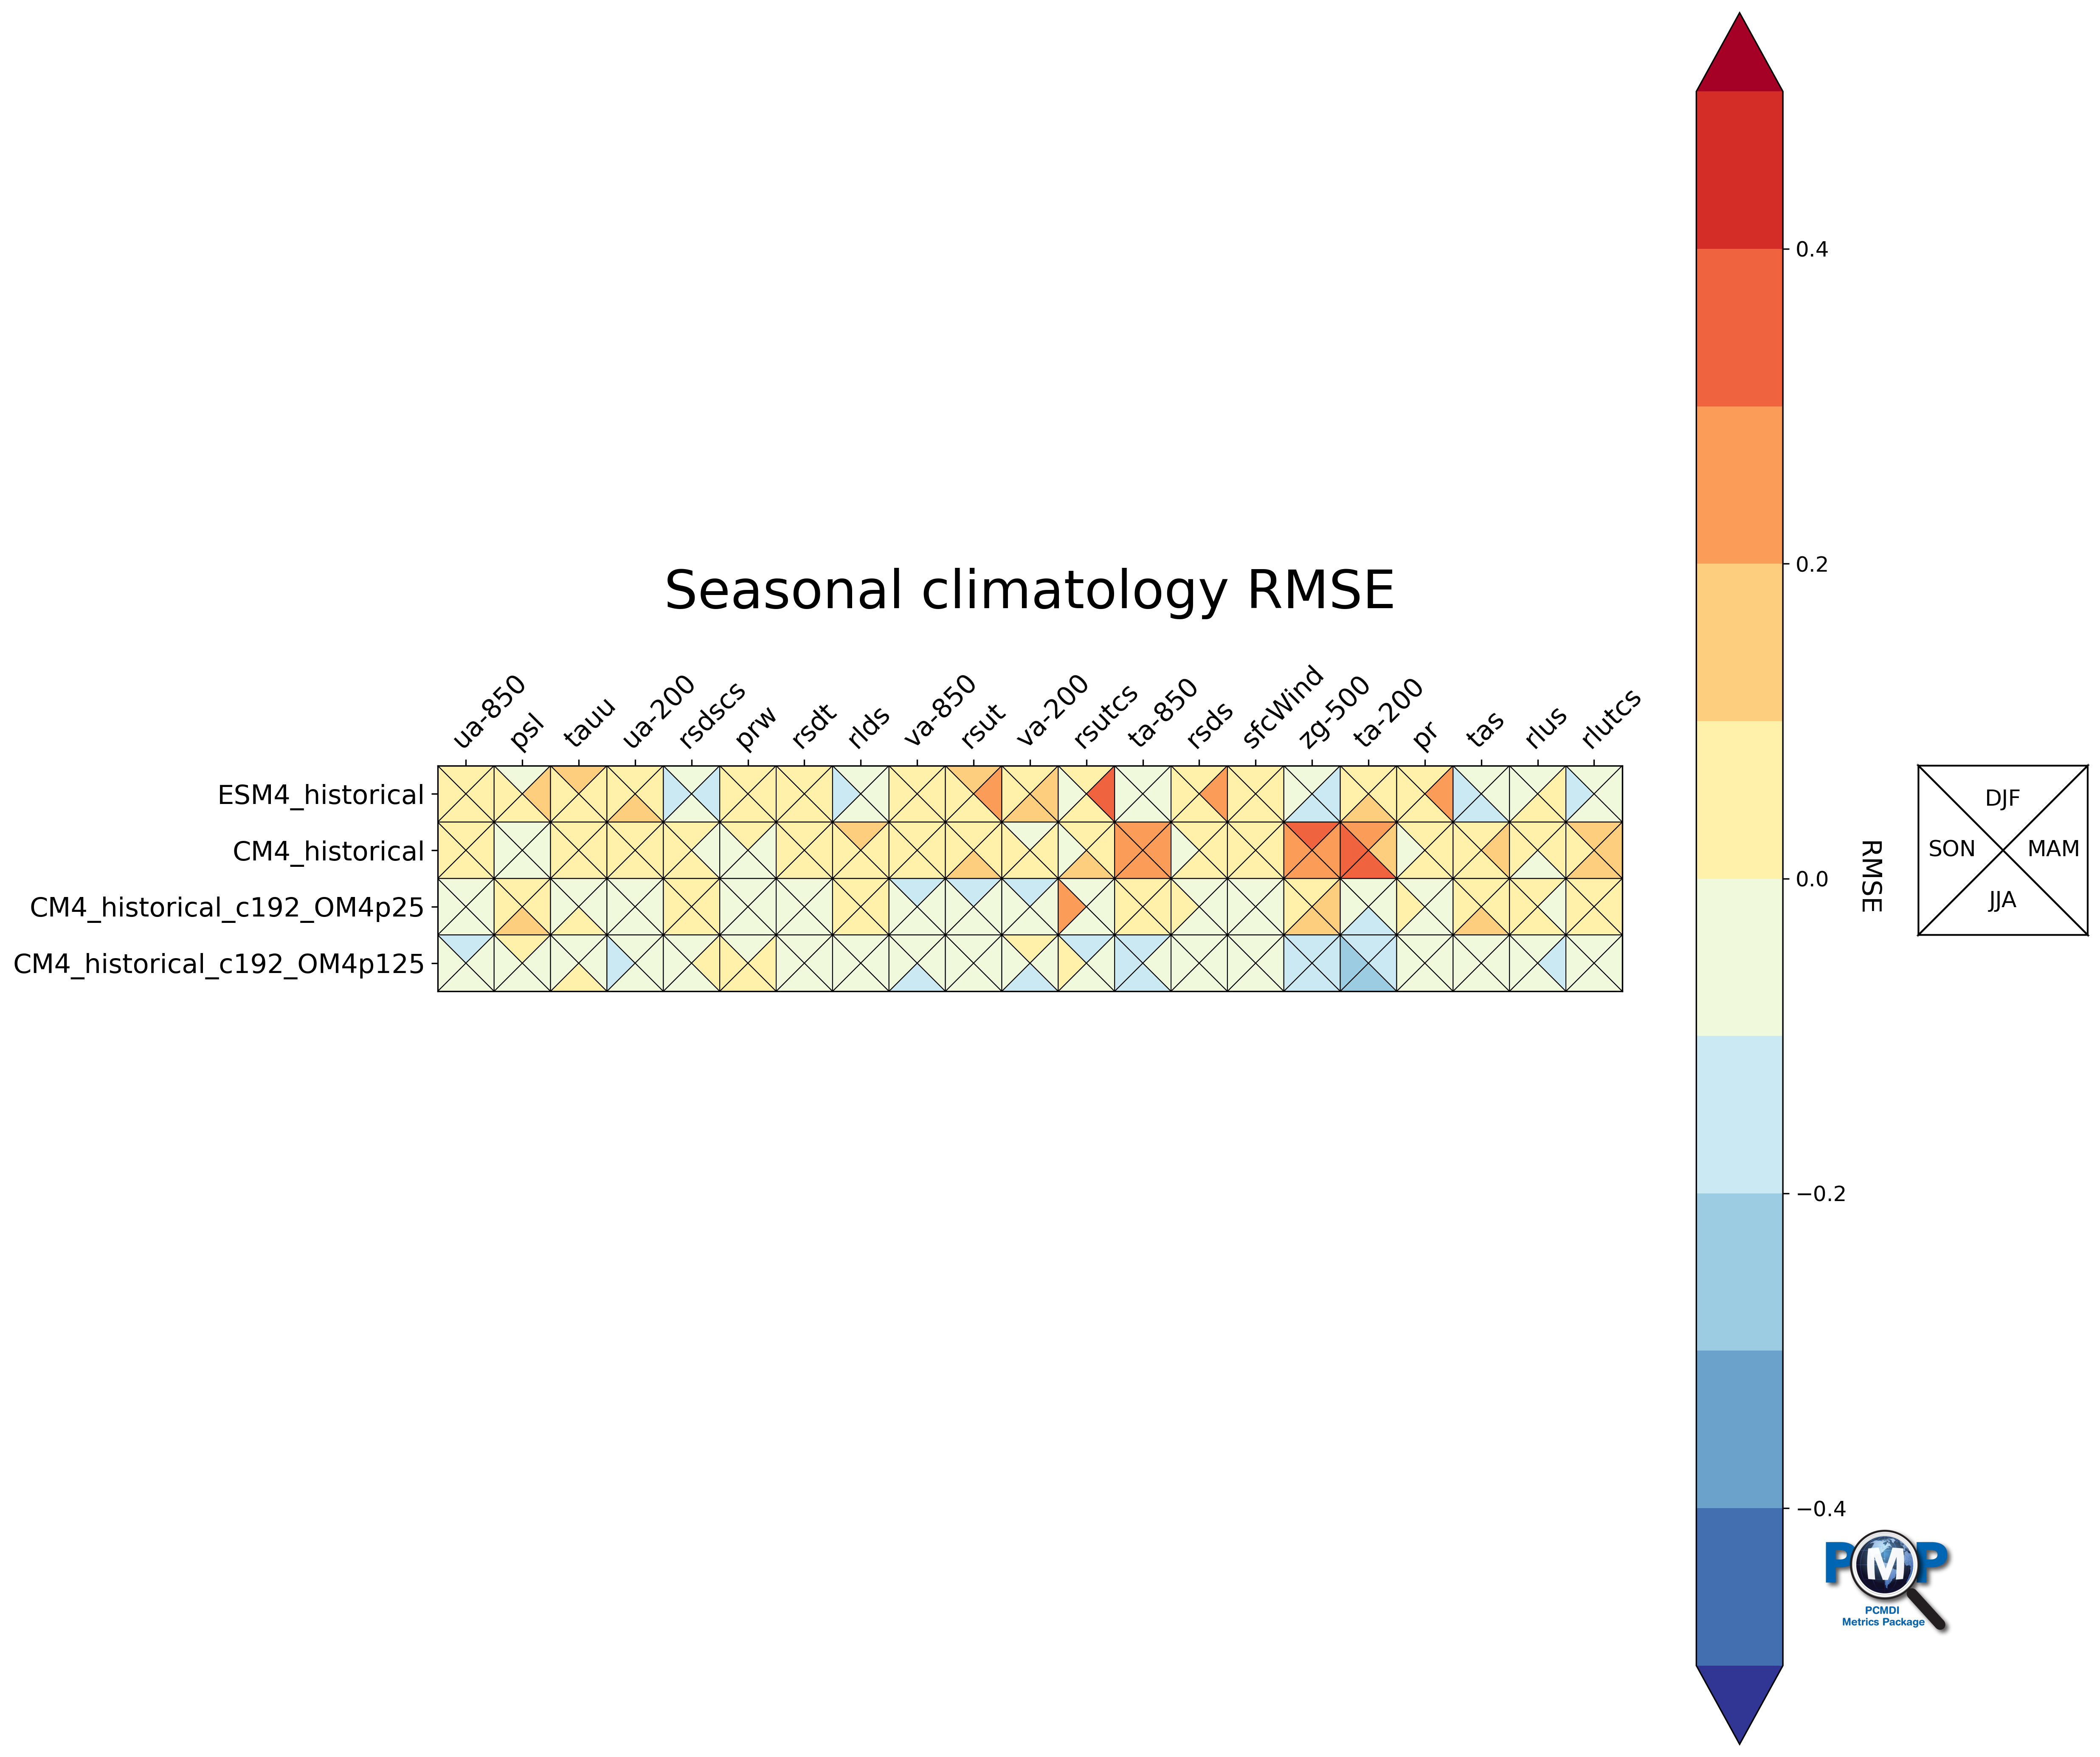

In [134]:
fig, ax, cbar = portrait_plot(data_all_nor,
                              xaxis_labels=xaxis_labels, 
                              yaxis_labels=yaxis_labels, 
                              cbar_label='RMSE',
                              box_as_square=True,
                              vrange=(-0.5, 0.5),
                              figsize=(15, 18),
                              cmap='RdYlBu_r',
                              cmap_bounds=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              cbar_kw={"extend": "both"},
                              missing_color='grey',
                              legend_on=True,
                              legend_labels=['DJF', 'MAM', 'JJA', 'SON'],
                              legend_box_xy=(1.25, 1),
                              legend_box_size=3,
                              legend_lw=1,
                              legend_fontsize=12.5,
                              logo_rect = [0.85, 0.15, 0.07, 0.07]
                             )
ax.set_xticklabels(xaxis_labels, rotation=45, va='bottom', ha="left")

# Add title
ax.set_title("Seasonal climatology RMSE", fontsize=30, pad=30)

# Add data info
#fig.text(1.25, 0.9, 'Data version\n'+data_version, transform=ax.transAxes,
#         fontsize=12, color='black', alpha=0.6, ha='left', va='top',)

In [135]:
# Save figure as an image file
fig.savefig('mean_clim_portrait_plot_4seasons_all_models.pdf', facecolor='w', bbox_inches='tight')

In [40]:
# Add Watermark
ax.text(0.5, 0.5, 'Example', transform=ax.transAxes,
        fontsize=100, color='black', alpha=0.6,
        ha='center', va='center', rotation='0')
# Save figure as an image file
fig.savefig('mean_clim_portrait_plot_4seasons_example.png', facecolor='w', bbox_inches='tight')

## 3.2 Portrait Plot with 4 Triangles (4 regions)


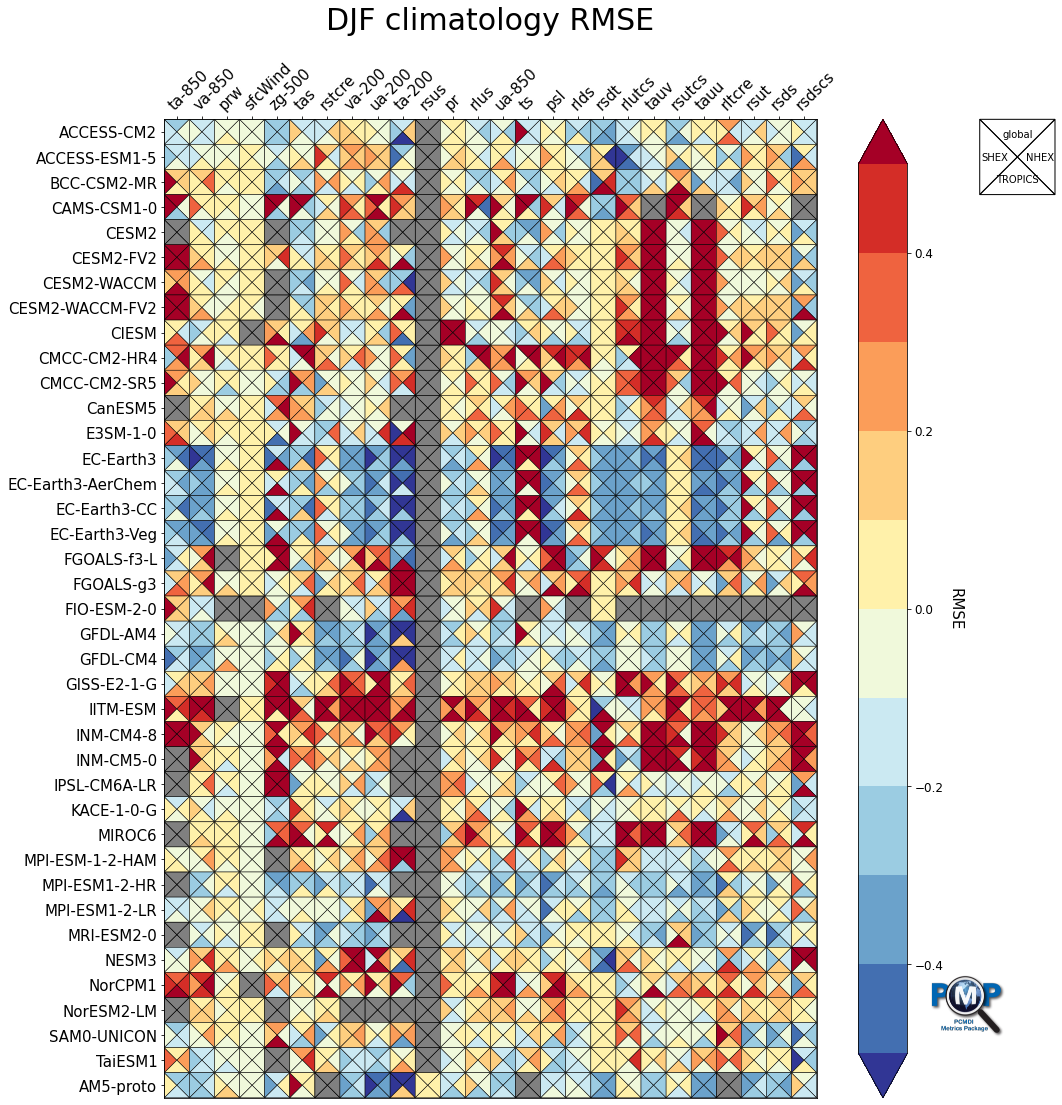

In [21]:
stat = 'rms_xy'
regions = ['global', 'NHEX', 'TROPICS', 'SHEX']

data1 = normalize_by_median(df_dict[stat]['djf']['global'][var_list].to_numpy())
data2 = normalize_by_median(df_dict[stat]['djf']['NHEX'][var_list].to_numpy())
data3 = normalize_by_median(df_dict[stat]['djf']['TROPICS'][var_list].to_numpy())
data4 = normalize_by_median(df_dict[stat]['djf']['SHEX'][var_list].to_numpy())

data_regions_nor = np.stack([data1, data2, data3, data4])

fig, ax, cbar = portrait_plot(data_regions_nor,
                              xaxis_labels=xaxis_labels, 
                              yaxis_labels=yaxis_labels, 
                              cbar_label='RMSE',
                              box_as_square=True,
                              vrange=(-0.5, 0.5),
                              figsize=(15, 18),
                              cmap='RdYlBu_r',
                              cmap_bounds=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              cbar_kw={"extend": "both"},
                              missing_color='grey',
                              legend_on=True,
                              legend_labels=regions,
                              legend_box_xy=(1.25, 1),
                              legend_box_size=3,
                              legend_lw=1,
                              legend_fontsize=10,
                              logo_rect = [0.85, 0.15, 0.07, 0.07]
                             )
ax.set_xticklabels(xaxis_labels, rotation=45, va='bottom', ha="left")

# Add title
ax.set_title("DJF climatology RMSE", fontsize=30, pad=30)

# Add data info
#fig.text(1.25, 0.9, 'Data version\n'+data_version, transform=ax.transAxes,
#         fontsize=12, color='black', alpha=0.6, ha='left', va='top',)

# Save figure as an image file
fig.savefig('mean_clim_portrait_plot_4regions.png', facecolor='w', bbox_inches='tight')

## 3.3 Portrait Plot with 2 Triangles (2 seasons)

Text(0.5, 1.0, 'Seasonal climatology RMSE')

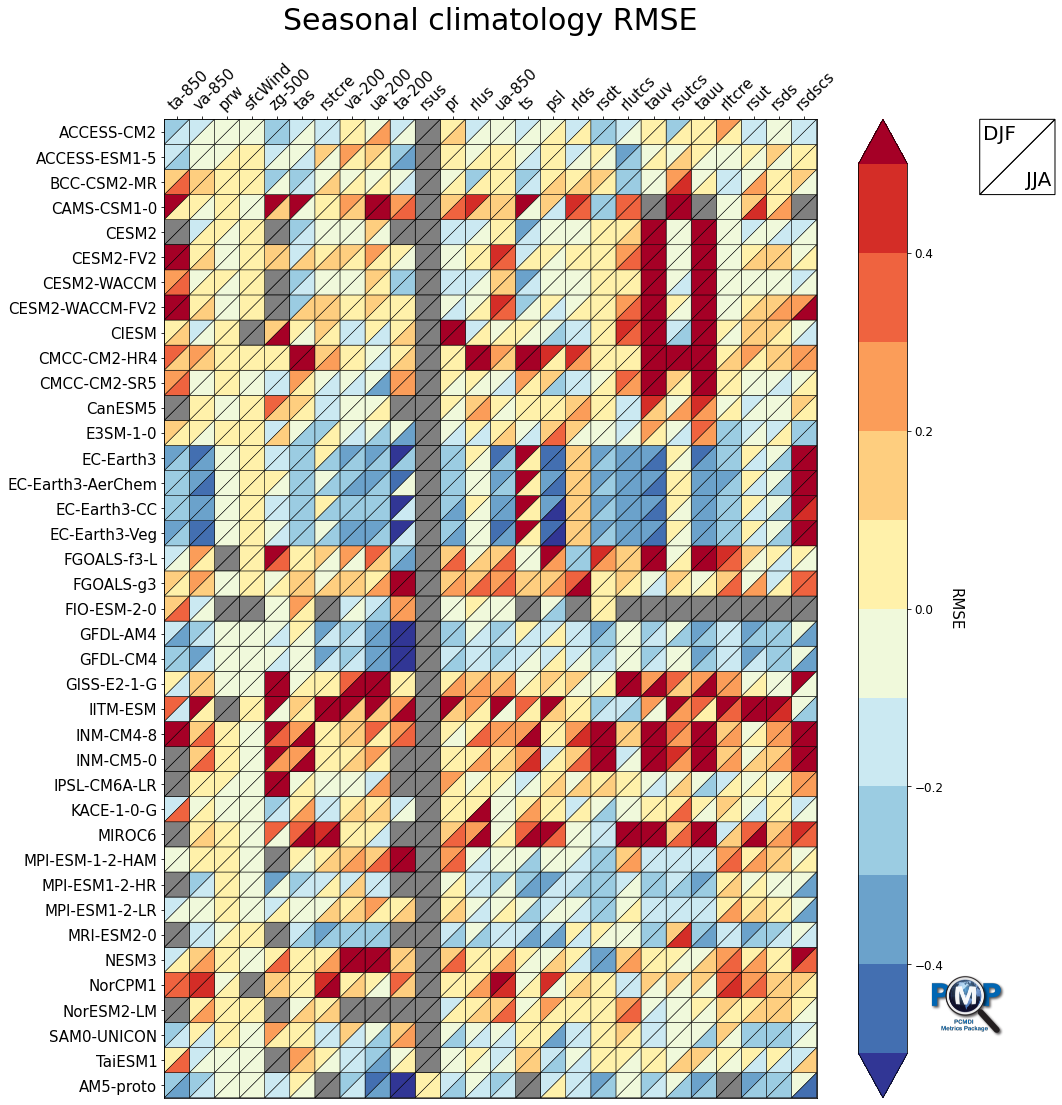

In [22]:
fig, ax, cbar = portrait_plot([data_djf_nor, data_jja_nor],
                              xaxis_labels=xaxis_labels, 
                              yaxis_labels=yaxis_labels, 
                              cbar_label='RMSE',
                              box_as_square=True,
                              vrange=(-0.5, 0.5),
                              figsize=(15, 18),
                              cmap='RdYlBu_r',
                              cmap_bounds=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              cbar_kw={"extend": "both"},
                              missing_color='grey',
                              legend_on=True,
                              legend_labels=['DJF', 'JJA'],
                              legend_box_xy = (1.25, 1),
                              legend_box_size=3,
                              legend_lw=1,
                              legend_fontsize=20,
                              logo_rect = [0.85, 0.15, 0.07, 0.07]
                             )
ax.set_xticklabels(xaxis_labels, rotation=45, va='bottom', ha="left")

# Add title
ax.set_title("Seasonal climatology RMSE", fontsize=30, pad=30)

## 3.4 Portrait Plot without Triangles (1 season)

Text(0.5, 1.0, 'Seasonal climatology RMSE: DJF')

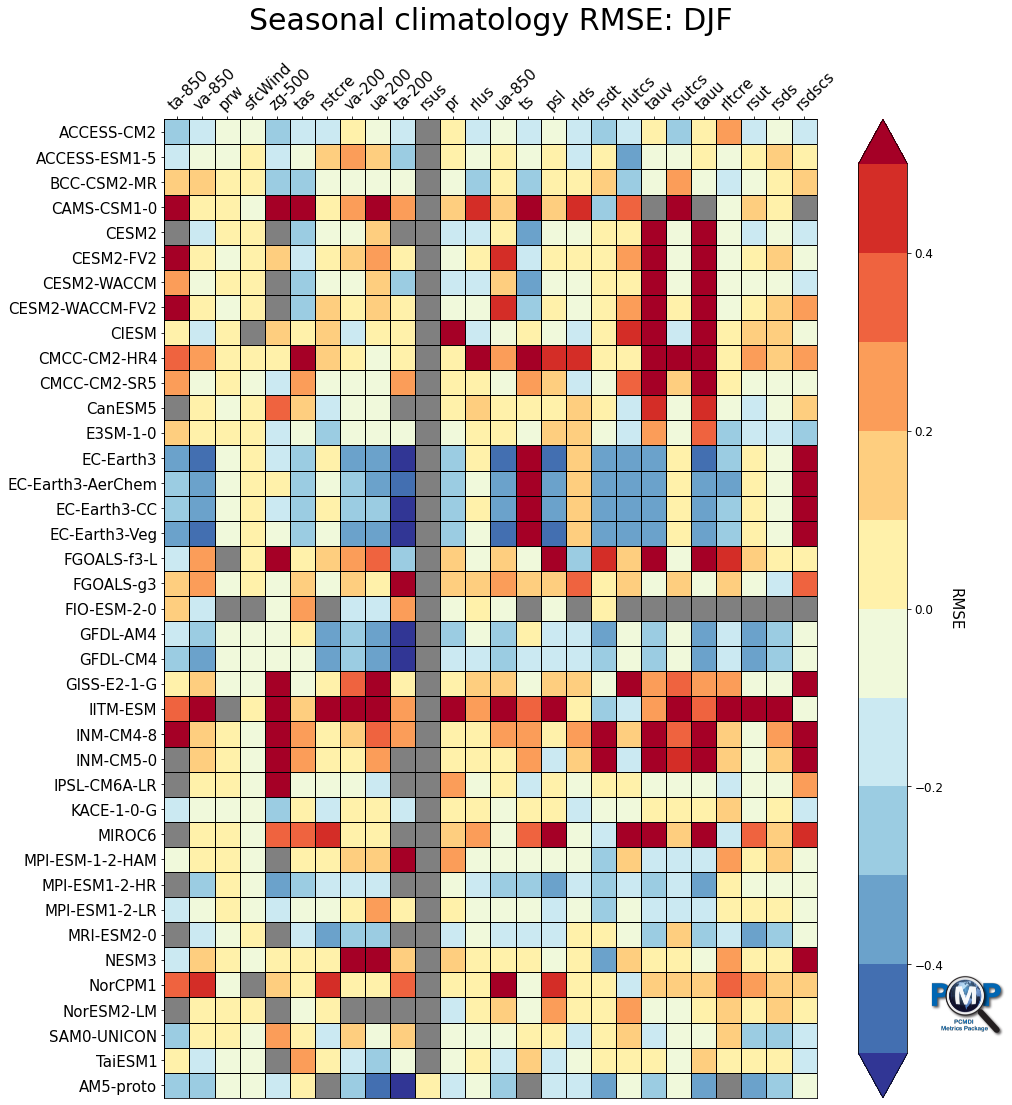

In [23]:
fig, ax, cbar = portrait_plot([data_djf_nor],
                              xaxis_labels=xaxis_labels, 
                              yaxis_labels=yaxis_labels, 
                              cbar_label='RMSE',
                              box_as_square=True,
                              vrange=(-0.5, 0.5),
                              figsize=(15, 18),
                              cmap='RdYlBu_r',
                              cmap_bounds=[-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              cbar_kw={"extend": "both"},
                              missing_color='grey',
                              logo_rect = [0.85, 0.15, 0.07, 0.07]
                             )
ax.set_xticklabels(xaxis_labels, rotation=45, va='bottom', ha="left")

# Add title
ax.set_title("Seasonal climatology RMSE: DJF", fontsize=30, pad=30)